In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

LOWER_DELETION_SIZE_LIMIT = 4000
UPPER_DELETION_SIZE_LIMIT = 10000
DELETION_ALLELE_FREQ_THRESHOLD = 0.00001

# Filter out false deletions: 
SUSPICIOUS_DELETION_SIZE_THRESHOLD = 1000000

DELETION_CLASS = 'observed' # TOPMED 

# DELETION_TYPE = 'long' 
DELETION_TYPE = 'all' 

PUBLIC_REPO = 'constraint-tools-data'
PUBLIC_REPO_DIR = f'/scratch/ucgd/lustre-work/quinlan/u6018199/{PUBLIC_REPO}'

CHEN_DATA_DIRECTORY = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM'
CHEN_FILE_STEM = 'Supplementary_Data_6_ESM'

## Compute SV scores of a set of positive and negative enhancers linked to genes that are known to be under negative selection or no selection, respectively


In [2]:
import pandas as pd 

def get_enhancer_coordinates(row):
  enhancer = row['enhancer']
  chrom, start, end = enhancer.strip().split('-')
  return chrom, int(start), int(end)

def make_bed_file_of_enhancers():
  df = pd.read_csv(f'{CHEN_DATA_DIRECTORY}/{CHEN_FILE_STEM}.txt', sep='\t')
  df[['enhancer_chrom', 'enhancer_start', 'enhancer_end']] = df.apply(get_enhancer_coordinates, axis=1, result_type='expand')
  cols = ['enhancer_chrom', 'enhancer_start', 'enhancer_end'] + [col for col in df.columns if col not in ['enhancer_chrom', 'enhancer_start', 'enhancer_end']]
  df = df[cols]
  bed_file = f'{CHEN_DATA_DIRECTORY}/{CHEN_FILE_STEM}.bed'
  df.to_csv(bed_file, sep='\t', index=False)
  return bed_file

make_bed_file_of_enhancers()

'/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_6_ESM.bed'

In [3]:
from shell import shell 
from aggregate import aggregate
import numpy as np

def assign_SV_scores_to_labeled_enhancers(
  deletion_class=DELETION_CLASS,
  deletion_type=DELETION_TYPE,
):
  windows = make_bed_file_of_enhancers()
  windows_with_deletions = f'{CHEN_DATA_DIRECTORY}/{CHEN_FILE_STEM}-intersect-{deletion_type}-{deletion_class}-deletions.bed'

  intersect_script = f'{CONSTRAINT_TOOLS}/experiments/germline-model/chen-et-al-2022/intersect-windows-with-deletions.sh'

  PROCESSED_DELETIONS = f'{deletion_type}-{deletion_class}-deletions.bed'

  cmd = (
    f'bash '
    f'{intersect_script} '
    f'{windows} {deletion_class} {windows_with_deletions} '
    f'{PUBLIC_REPO_DIR} {PROCESSED_DELETIONS} '
    f'{deletion_type} '
    f'{LOWER_DELETION_SIZE_LIMIT} {UPPER_DELETION_SIZE_LIMIT} {DELETION_ALLELE_FREQ_THRESHOLD} '
    f'{SUSPICIOUS_DELETION_SIZE_THRESHOLD}'
  )
  print(shell(cmd))

  df = pd.read_csv(
    windows_with_deletions, 
    sep='\t',
  )

  df = df[
    (df['enhancer_chrom'] != 'chrX') &
    (df['enhancer_chrom'] != 'chrY')
  ]

  # though unlikely, some enhancers may intersect multiple merged (and therefore non-overlapping) deletions,
  # therefore group by enhancer (and deletion count), and compute "sum merged_deletion_overlap" in each group,
  group_columns = df.columns.tolist()[:-4]
  df = aggregate(
    df, 
    group_columns = group_columns,
    aggregation_functions = {
      'merged_deletion_overlap': [np.sum],
    }
  )

  df['enhancer coordinates'] = df['enhancer_chrom'] + ':' + df['enhancer_start'].astype(str) + '-' + df['enhancer_end'].astype(str)
  df = df.drop(columns=['enhancer'])
  
  df['enhancer_length'] = df['enhancer_end'] - df['enhancer_start']

  df['deletion count per bp'] = df['deletion_count'] / df['enhancer_length']
  df['fraction of bps that are deleted'] = df['sum merged_deletion_overlap'] / df['enhancer_length']

  df = df.drop(columns=['LOEUF underpowered'])

  constrained_labels = ['Haploinsufficient', 'MGI essential',	'OMIM dominant', 'LOEUF constrained']
  constrained_enhancers = df[df[constrained_labels].any(axis=1)]

  unconstrained_labels = ['Olfactory', 'LOEUF unconstrained']
  unconstrained_enhancers = df[df[unconstrained_labels].any(axis=1)]
  
  ambiguous_enhancers = pd.merge(constrained_enhancers, unconstrained_enhancers, how='inner')

  constrained_enhancers = pd.merge(constrained_enhancers, ambiguous_enhancers, how='outer', indicator=True)
  constrained_enhancers = constrained_enhancers[constrained_enhancers['_merge'] == 'left_only']
  constrained_enhancers = constrained_enhancers.drop(columns=['_merge'])
  constrained_enhancers['truly constrained'] = True

  unconstrained_enhancers = pd.merge(unconstrained_enhancers, ambiguous_enhancers, how='outer', indicator=True)
  unconstrained_enhancers = unconstrained_enhancers[unconstrained_enhancers['_merge'] == 'left_only']
  unconstrained_enhancers = unconstrained_enhancers.drop(columns=['_merge'])
  unconstrained_enhancers['truly constrained'] = False

  df = pd.concat([constrained_enhancers, unconstrained_enhancers])
  df = df.reset_index(drop=True)
  return df 

LABELED_EXAMPLES = assign_SV_scores_to_labeled_enhancers()
LABELED_EXAMPLES

We assume that the first line of the following is a header line: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_6_ESM.bed
Wrote windows with deletion counts and overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_6_ESM-intersect-all-observed-deletions.bed
Wrote all observed deletions in UCSC-genome-browser format to: /scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools-data/all-observed-deletions.bed
Everything up-to-date
Pushed /scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools-data/all-observed-deletions.bed to public repo
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


,enhancer_chrom,enhancer_start,enhancer_end,gene,enhancer_Gnocchi,Haploinsufficient,MGI essential,OMIM dominant,LOEUF constrained,Olfactory,LOEUF unconstrained,deletion_count,sum merged_deletion_overlap,enhancer coordinates,enhancer_length,deletion count per bp,fraction of bps that are deleted,truly constrained
0,chr1,2545161,2545361,PANK4,2.775673,False,False,True,False,False,False,0,0,chr1:2545161-2545361,200,0.0000,0.000,True
1,chr1,3208836,3209036,PRDM16,6.070480,False,True,True,True,False,False,0,0,chr1:3208836-3209036,200,0.0000,0.000,True
2,chr1,3670636,3671636,TP73,5.884122,False,True,False,True,False,False,2,1000,chr1:3670636-3671636,1000,0.0020,1.000,True
3,chr1,4654140,4654540,AJAP1,5.098327,False,False,False,True,False,False,1,400,chr1:4654140-4654540,400,0.0025,1.000,True
4,chr1,6071940,6072140,CHD5,8.484611,False,False,False,True,False,False,2,200,chr1:6071940-6072140,200,0.0100,1.000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4030,chr9,122807921,122808121,OR1L4,3.383762,False,False,False,False,True,False,0,37,chr9:122807921-122808121,200,0.0000,0.185,False
4031,chr9,122807921,122808721,OR1L3,3.383762,False,False,False,False,True,False,0,228,chr9:122807921-122808721,800,0.0000,0.285,False
4032,chr9,122807921,122808921,OR1K1,3.383762,False,False,False,False,True,False,0,428,chr9:122807921-122808921,1000,0.0000,0.428,False
4033,chr9,122807921,122808921,OR1L6,3.383762,False,False,False,False,True,False,0,428,chr9:122807921-122808921,1000,0.0000,0.428,False


## Plot the distribution of SNV and SV scores of positive and negative enhancers

In [16]:
LABELED_EXAMPLES['negative_enhancer_Gnocchi'] = -LABELED_EXAMPLES['enhancer_Gnocchi']

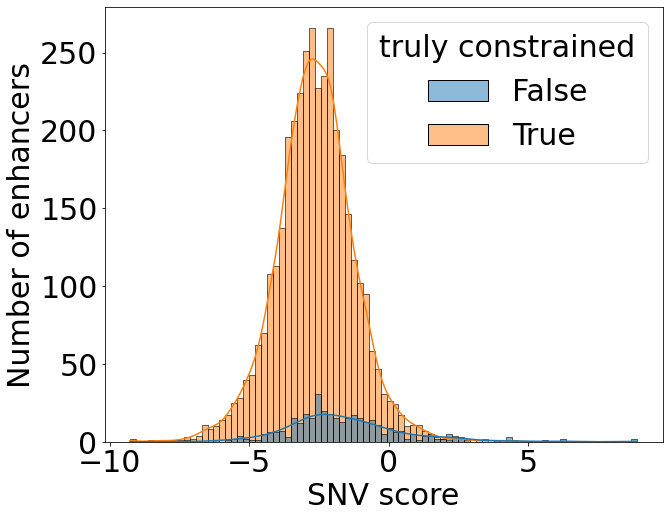

constrained = False; SNV score = 1.5357997895404818 +/- 2.1267013032683555
constrained = True; SNV score = 2.635262454423334 +/- 1.4060832812716995
negative enhancers 0.013444505473803686
positive enhancers 0.002311561017834782


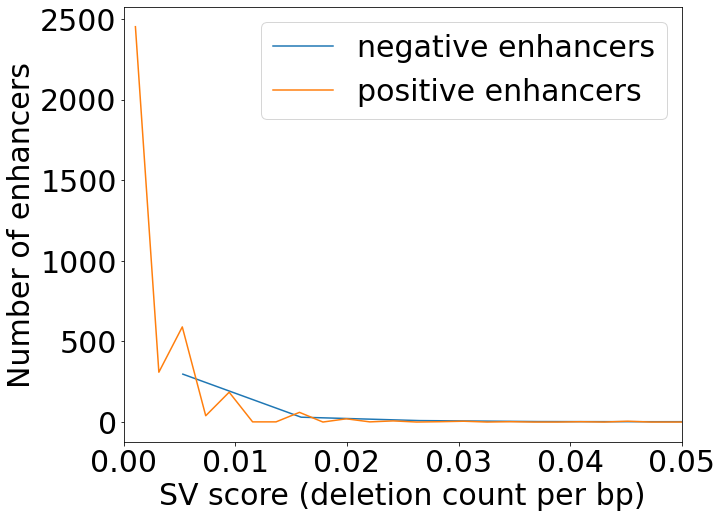

negative enhancers 0.6269466477809253
positive enhancers 0.4075377964874163


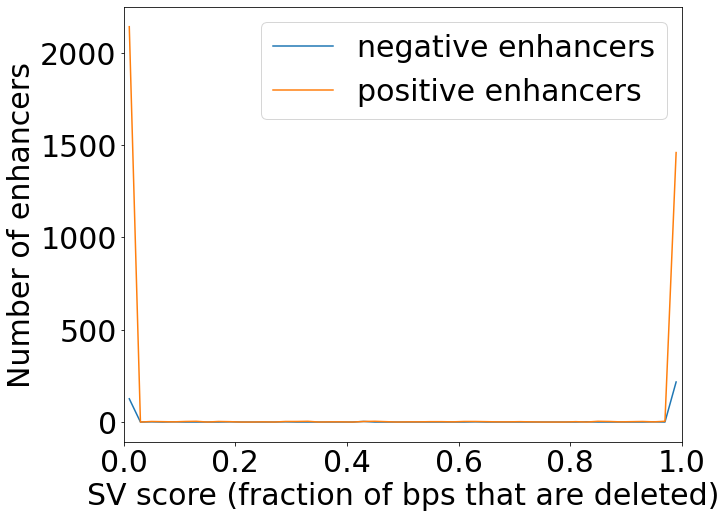

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font size
mpl.rcParams['font.size'] = 30
plt.rcParams['figure.figsize'] = (10, 8)

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.histplot(data=LABELED_EXAMPLES, x='negative_enhancer_Gnocchi', hue='truly constrained', kde=True)
plt.xlabel('SNV score')
plt.ylabel('Number of enhancers')
plt.show()

def filter_scores_on_constraint(df, constrained, score): 
  df = df[df['truly constrained'] == constrained]
  ser = df[score]
  return ser

def print_mean_SNV_score(constrained):
  scores = filter_scores_on_constraint(LABELED_EXAMPLES, constrained=constrained, score='enhancer_Gnocchi')
  print(f'constrained = {constrained}; SNV score = {scores.mean()} +/- {scores.std()}')

print_mean_SNV_score(constrained=False)
print_mean_SNV_score(constrained=True)

def plot_distribution(ser, label): 
  print(label, ser.mean())
  counts, edges = np.histogram(ser, bins=50)
  total_count = np.sum(counts)
  centers = (edges[:-1] + edges[1:]) / 2
  # plt.plot(centers, counts/total_count, label=label, alpha=1)
  plt.plot(centers, counts, label=label, alpha=1)

def plot_distributions(df, score, score_alias, xlim):
  plot_distribution(filter_scores_on_constraint(df, constrained=False, score=score), label='negative enhancers')
  plot_distribution(filter_scores_on_constraint(df, constrained=True, score=score), label='positive enhancers')
  plt.legend()
  plt.xlabel(score_alias)
  # plt.ylabel('Fraction of enhancers')
  plt.ylabel('Number of enhancers')
  plt.xlim(xlim)
  plt.show()

plot_distributions(
  LABELED_EXAMPLES, 
  score='deletion count per bp',
  score_alias='SV score (deletion count per bp)', 
  xlim=(0, 0.05)
)

plot_distributions(
  LABELED_EXAMPLES, 
  score='fraction of bps that are deleted',
  score_alias='SV score (fraction of bps that are deleted)',
  xlim=(0, 1)
)

## SNV-only classifier

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

def predict_constraint(df, features, prob_threshold): 
  X = df[features]
  y = df['truly constrained']

  # model = LinearDiscriminantAnalysis()
  # model = QuadraticDiscriminantAnalysis()
  model = LogisticRegression() 

  model.fit(X, y)

  df['predicted to be constrained'] = model.predict_proba(X)[:, 1] > prob_threshold

  return df 

# SNV-only classifier 
predict_constraint(
  LABELED_EXAMPLES, 
  features=['enhancer_Gnocchi'], 
  prob_threshold=0.95
)

,enhancer_chrom,enhancer_start,enhancer_end,gene,enhancer_Gnocchi,Haploinsufficient,MGI essential,OMIM dominant,LOEUF constrained,Olfactory,LOEUF unconstrained,deletion_count,sum merged_deletion_overlap,enhancer coordinates,enhancer_length,deletion count per bp,fraction of bps that are deleted,truly constrained,predicted to be constrained
0,chr1,2545161,2545361,PANK4,2.775673,False,False,True,False,False,False,0,0,chr1:2545161-2545361,200,0.0000,0.000,True,False
1,chr1,3208836,3209036,PRDM16,6.070480,False,True,True,True,False,False,0,0,chr1:3208836-3209036,200,0.0000,0.000,True,True
2,chr1,3670636,3671636,TP73,5.884122,False,True,False,True,False,False,2,1000,chr1:3670636-3671636,1000,0.0020,1.000,True,True
3,chr1,4654140,4654540,AJAP1,5.098327,False,False,False,True,False,False,1,400,chr1:4654140-4654540,400,0.0025,1.000,True,True
4,chr1,6071940,6072140,CHD5,8.484611,False,False,False,True,False,False,2,200,chr1:6071940-6072140,200,0.0100,1.000,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4030,chr9,122807921,122808121,OR1L4,3.383762,False,False,False,False,True,False,0,37,chr9:122807921-122808121,200,0.0000,0.185,False,False
4031,chr9,122807921,122808721,OR1L3,3.383762,False,False,False,False,True,False,0,228,chr9:122807921-122808721,800,0.0000,0.285,False,False
4032,chr9,122807921,122808921,OR1K1,3.383762,False,False,False,False,True,False,0,428,chr9:122807921-122808921,1000,0.0000,0.428,False,False
4033,chr9,122807921,122808921,OR1L6,3.383762,False,False,False,False,True,False,0,428,chr9:122807921-122808921,1000,0.0000,0.428,False,False


In [6]:
def compute_precision_recall(df, log): 
  contingency_table = pd.crosstab(
    df['predicted to be constrained'], 
    df['truly constrained']
  )

  if log: print(contingency_table)

  tp = contingency_table.loc[True, True]
  fp = contingency_table.loc[True, False]
  fn = contingency_table.loc[False, True]
  precision = tp / (tp + fp) # type: ignore
  recall = tp / (tp + fn) # type: ignore

  return precision, recall

def predict_and_compute_precision_recall(df, features, prob_threshold, log=False): 
  if log: print(prob_threshold)
  df = predict_constraint(df, features, prob_threshold)
  precision, recall = compute_precision_recall(df, log)
  return precision, recall
  
predict_and_compute_precision_recall(
  LABELED_EXAMPLES, 
  features=['enhancer_Gnocchi'], 
  prob_threshold=0.95
)

(0.9569060773480663, 0.2351982618142314)

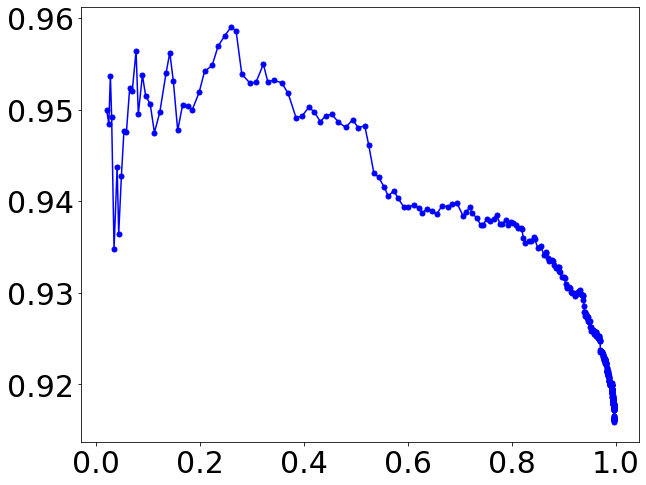

In [7]:
def plot_precision_recall(df, features, prob_thresholds, color, log=False): 
  precision_recall = [
    predict_and_compute_precision_recall(df, features, prob_threshold, log=log)
    for prob_threshold in prob_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  # set marker size 
  plt.plot(recalls, precisions, label=f'using {features}', color=color, marker='o', markersize=5)

plot_precision_recall(
  LABELED_EXAMPLES, 
  features=['enhancer_Gnocchi'], 
  prob_thresholds=np.arange(0.60, 0.98, 0.001),
  color='blue',
  log=False
)

## Naive SV classifier 

In [8]:
def predict_and_compute_precision_recall_under_naive_SV_classifier(df, score, score_threshold):
  df['predicted to be constrained'] = df[score] < score_threshold
  TP = df[(df['truly constrained'] == True) & (df['predicted to be constrained'] == True)].shape[0]
  FP = df[(df['truly constrained'] == False) & (df['predicted to be constrained'] == True)].shape[0]
  FN = df[(df['truly constrained'] == True) & (df['predicted to be constrained'] == False)].shape[0]
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  return precision, recall

predict_and_compute_precision_recall_under_naive_SV_classifier(
  LABELED_EXAMPLES, 
  score='fraction of bps that are deleted', 
  score_threshold=0.1
)

(0.9437609841827768, 0.5833785985877241)

In [9]:
predict_and_compute_precision_recall_under_naive_SV_classifier(
  LABELED_EXAMPLES, 
  score='deletion count per bp', 
  score_threshold=0.01
)

(0.9272428884026258, 0.9206952743074416)

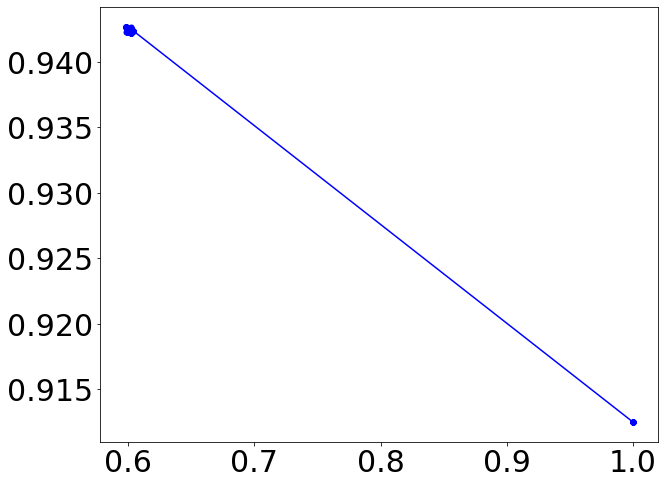

In [10]:
def plot_precision_recall_under_naive_SV_classifier(df, score, score_thresholds, color): 
  precision_recall = [
    predict_and_compute_precision_recall_under_naive_SV_classifier(
      df, 
      score, 
      score_threshold
    )
    for score_threshold in score_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(
    recalls, 
    precisions, 
    label=f'naive SV classifier (thresholding "{score}")', 
    color=color,
    marker='o',
    markersize=5
  )

plot_precision_recall_under_naive_SV_classifier(
  LABELED_EXAMPLES, 
  score='fraction of bps that are deleted',
  score_thresholds=np.arange(0.800, 1.020, 0.001),
  color='blue',
)

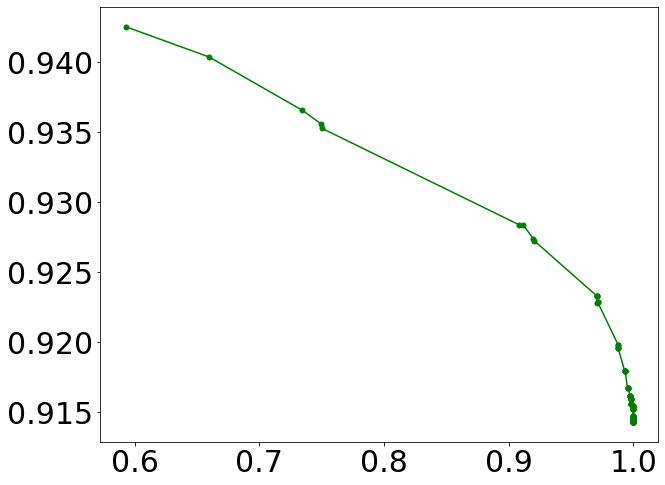

In [11]:
plot_precision_recall_under_naive_SV_classifier(
  LABELED_EXAMPLES, 
  score='deletion count per bp',
  score_thresholds=np.arange(0.001, 0.100, 0.001),
  color='green',
)

## Baseline classifier

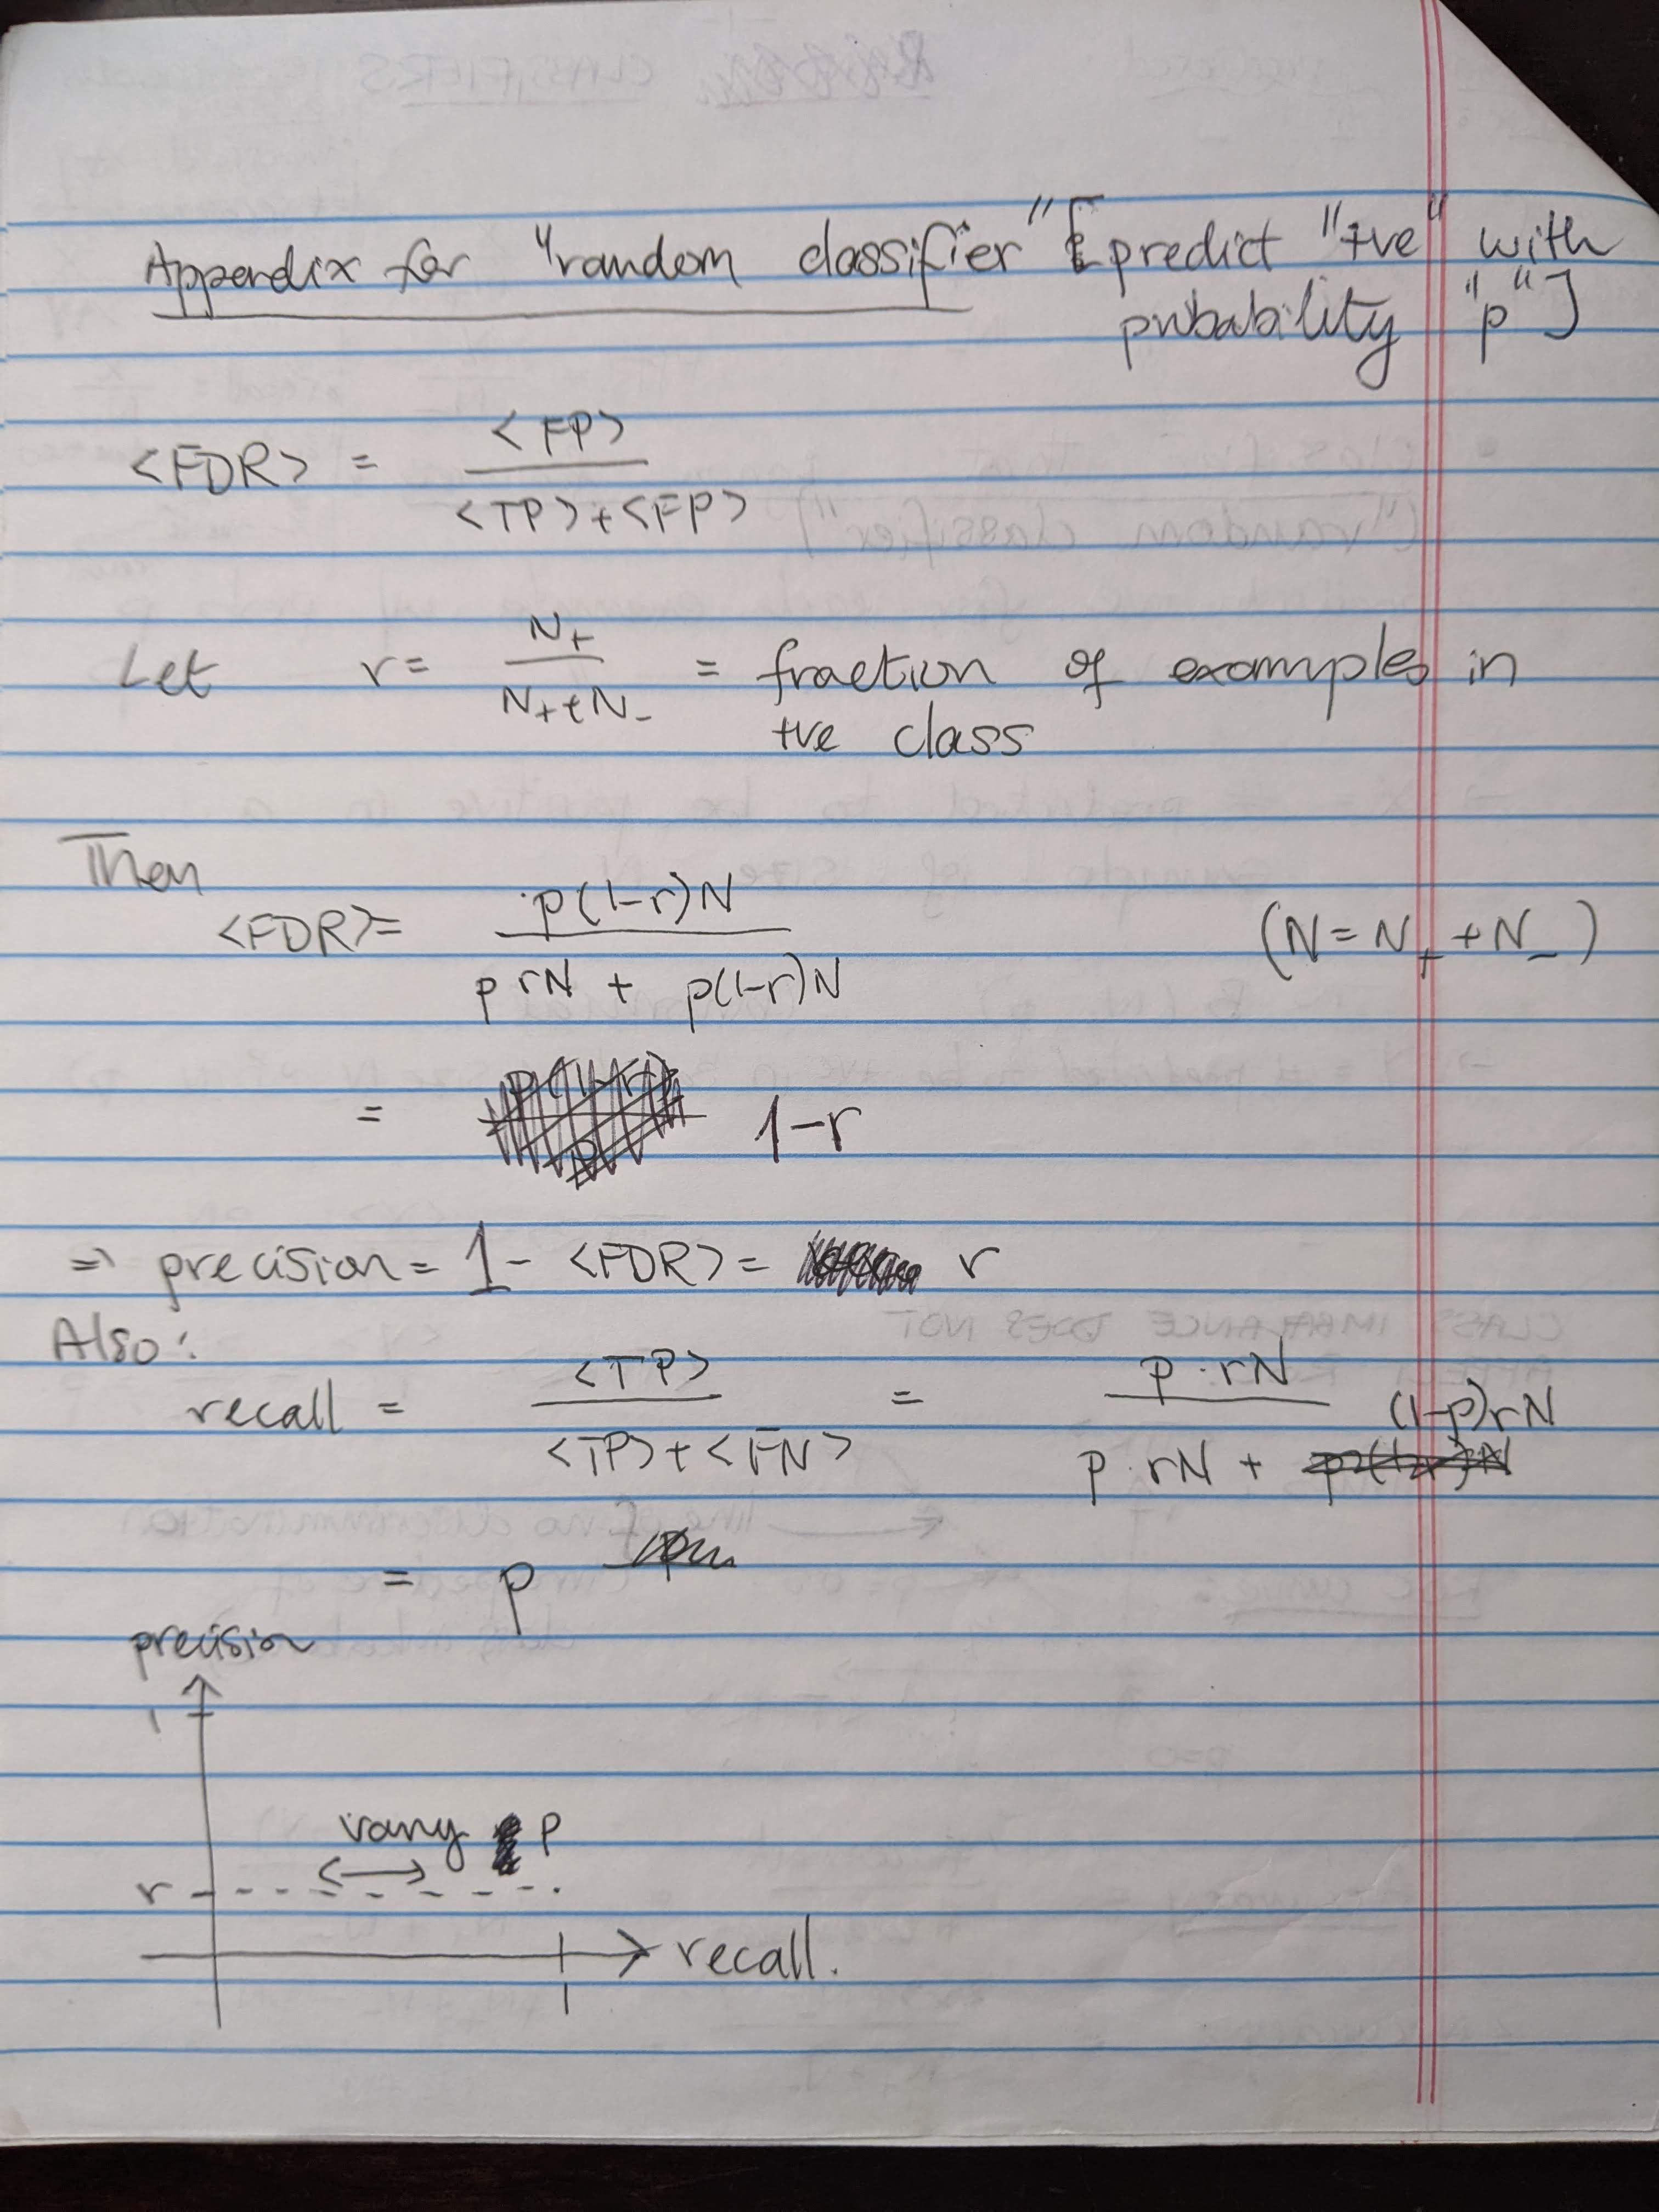

In [12]:
from IPython.display import Image # type: ignore
Image(filename='precision_recall_random_classifier.jpg', width=600)

## Compare all classifiers in one PR plot

In [13]:
def compute_positive_fraction(df):
  # this is "r" in the baseline-classifier theory 
  number_negative_examples = df['truly constrained'].value_counts().loc[False]
  number_positive_examples = df['truly constrained'].value_counts().loc[True]
  return number_positive_examples / (number_negative_examples + number_positive_examples)

compute_positive_fraction(LABELED_EXAMPLES)

0.9125154894671623

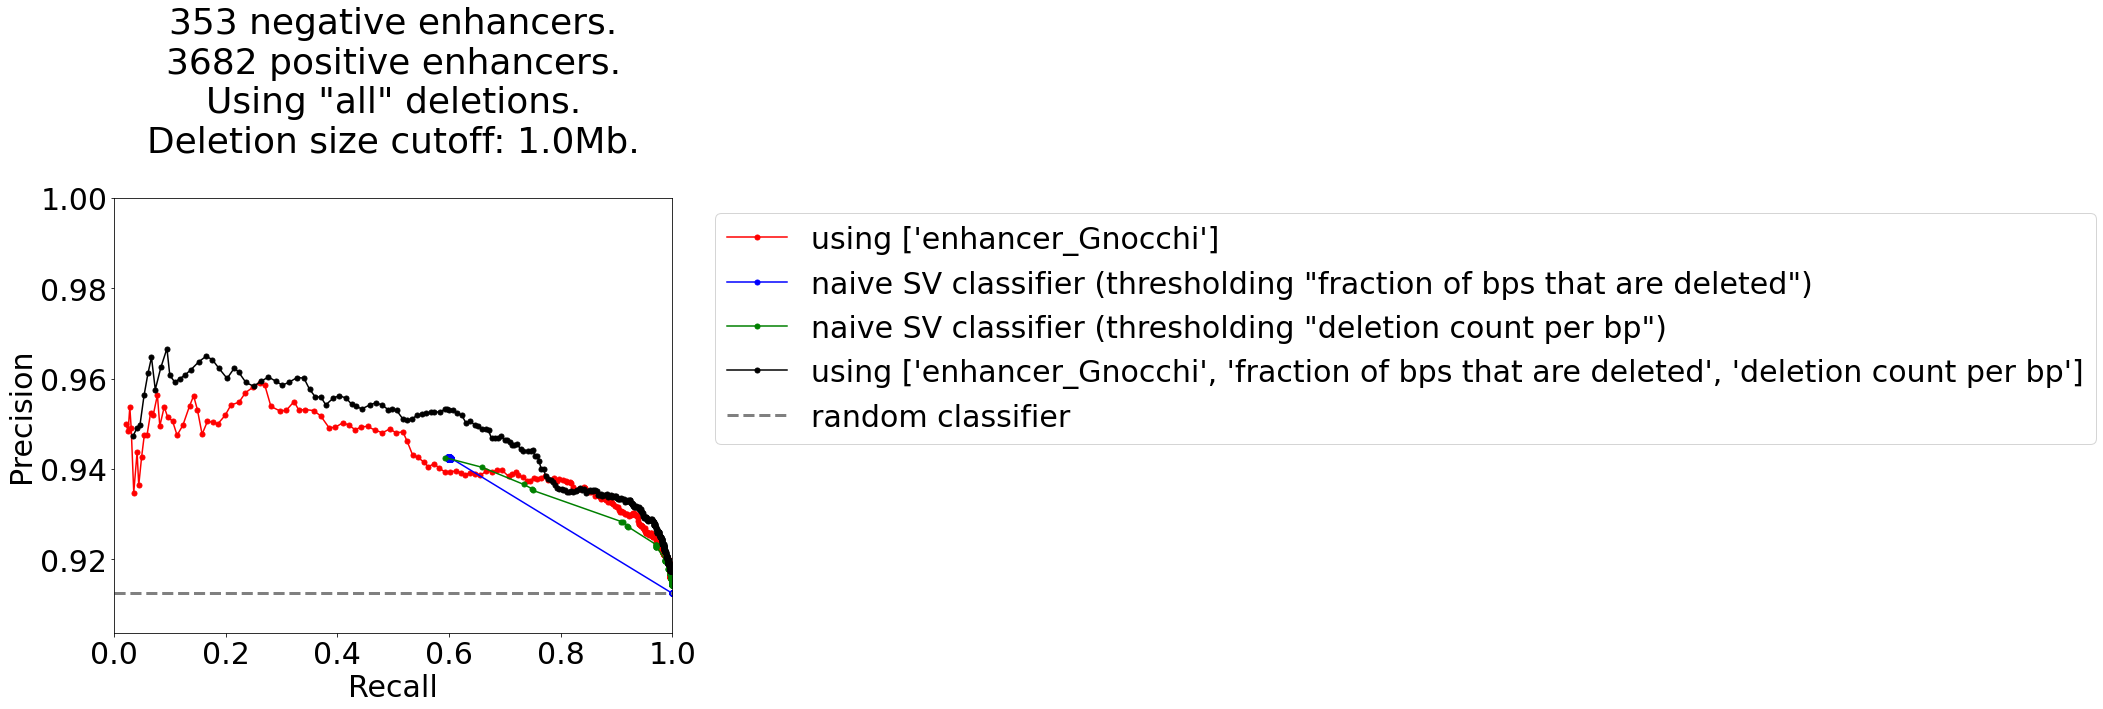

In [14]:
def plot_precision_recall_for_all_classifiers(df, plot_combined_classifier): 
  # SNV-only classifier
  plot_precision_recall(
    LABELED_EXAMPLES, 
    features=['enhancer_Gnocchi'], 
    prob_thresholds=np.arange(0.60, 0.98, 0.001),
    color='red',
    log=False
  )

  # naive SV classifier
  plot_precision_recall_under_naive_SV_classifier(
    LABELED_EXAMPLES, 
    score='fraction of bps that are deleted',
    score_thresholds=np.arange(0.800, 1.020, 0.001),
    color='blue',
  )  
  plot_precision_recall_under_naive_SV_classifier(
    LABELED_EXAMPLES, 
    score='deletion count per bp',
    score_thresholds=np.arange(0.001, 0.100, 0.001),
    color='green',
  )

  if plot_combined_classifier: 
    # SNV+SV classifier
    plot_precision_recall(
      df, 
      features=[
        'enhancer_Gnocchi', 
        'fraction of bps that are deleted', 
        'deletion count per bp'
      ], 
      prob_thresholds=np.arange(0.60, 0.98, 0.001),
      color='black',
    )

  # random classifier
  r = compute_positive_fraction(df)
  plt.plot([0, 1], [r, r], linestyle='--', linewidth=3, color='grey', label='random classifier')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.xlim(0, 1)
  plt.ylim(r - (1-r)*0.1, 1)

  number_negative_examples = df['truly constrained'].value_counts().loc[False]
  number_positive_examples = df['truly constrained'].value_counts().loc[True]
  plt.title(
    f'{number_negative_examples} negative enhancers.\n'
    f'{number_positive_examples} positive enhancers.\n'
    f'Using "{DELETION_TYPE}" deletions.\n'
    f'Deletion size cutoff: {SUSPICIOUS_DELETION_SIZE_THRESHOLD/1000000}Mb.\n'
  )
  
plot_precision_recall_for_all_classifiers(LABELED_EXAMPLES, plot_combined_classifier=True)